<h1>In this file we are processing the results of the population synthesis calculations with orbital evolution due to mass loss</h1>

In [1]:
# library imports
import numpy as np
from matplotlib import pyplot as plt
import sys
from astropy.table import Table, vstack
from astropy.io import fits
from scipy.integrate import solve_ivp
from scipy import interpolate
import time
# this is the library of helper functions provided separately, should be in the same folder as the notebook
import orbital

###Plot formatting commands
plt.rc('figure', figsize=(6,5)) 
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands

In [2]:
# reading in the results of the calculations:
hdul=fits.open('public_mybinaries_setup.fits')
temp = Table(hdul[1].data) # assuming the first extension is a table
hdul.close()
print(len(temp))
# we actually processed only the first 1e6 objects
nbinaries=1000000
mybinaries=temp[0:nbinaries]
print(len(mybinaries))

ind0=(mybinaries['class']==0)
ind1=(mybinaries['class']==1)
ind2=(mybinaries['class']==2)
# OK, let's split the table into three:
temp0=Table(mybinaries[ind0], copy=True)
mybin1=Table(mybinaries[ind1], copy=True)
temp2=Table(mybinaries[ind2], copy=True)
# let's get this straight - how many of each class do we have?
print(len(temp0),len(mybin1),len(temp2))

# read the results of the calculations for WD-MS binaries and for WD-WD binaries:
hdul=fits.open('public_evolution_mybin0.fits')
mybin0=Table(hdul[1].data)
hdul.close()
hdul=fits.open('public_evolution_mybin2.fits')
mybin2=Table(hdul[1].data)
hdul.close()
print(len(mybin0),len(mybin1),len(mybin2))

10000000
1000000
280763 685080 34157
280763 685080 34157


In [3]:
# let's read singles in:
hdul=fits.open('public_mysingles_setup.fits')
mysingles = Table(hdul[1].data) # assuming the first extension is a table
hdul.close()
nsingles=len(mysingles)
print(nsingles)

10000000


In [4]:
mysingles[0:5]

m,bday,death,class,fm
float64,float64,float64,float64,float64
0.5928911088877724,7.8510379222504305,62.7699956233224,0.0,0.39673701430875763
0.39573030510042073,3.9452779887960796,234.02193719423843,0.0,0.26480555596719724
0.40437008296347554,4.7935173824967094,217.8948506462203,0.0,0.2705869205758004
0.34581442464725104,2.195398905373514,373.1483547056577,0.0,0.23140401379407619
0.322593324704815,6.933994859595209,481.04662159392024,0.0,0.21586546089283645


In [5]:
present_day=12.0 # in Gyr
mybin0['age']=present_day-mybin0['bday']
mybin1['age']=present_day-mybin1['bday']
mybin2['age']=present_day-mybin2['bday']
mysingles['age']=present_day-mysingles['bday']

<h1>OK, let's make some statistics / fractions plots</h1>

In [6]:
# These are the defining variables for what we consider singles vs wide binaries
awide=1000.
alimit=1e4  # the wide binaries are those betwen awide and alimit
aclose=100. # this is the only variable that's necessary for defining effective singles

In [7]:
# let's identify objects that are effective singles
# from mybin1 all of the compact binaries:
ind0=(mybin1['sma']<aclose)
eff_singles0=Table([mybin1['m1'][ind0],np.full(len(mybin1[ind0]),0),mybin1['fm1'][ind0],mybin1['bday'][ind0]], names=('m', 'class', 'fm', 'bday'), copy=True)

# In the MS-WD table, close binaries are singles with the surviving MS mass
ind1=((mybin0['fsma']<aclose) & (mybin0['fsma']>0))
eff_singles1=Table([mybin0['m2'][ind1],np.full(len(mybin0[ind1]),0),mybin0['fm2'][ind1],mybin0['bday'][ind1]], names=('m', 'class', 'fm', 'bday'), copy=True)

# disrupted binaries are singles:
ind2=(mybin0['fsma']<0)
# the more massive star is the WD
eff_singles2a=Table([mybin0['m1'][ind2],np.full(len(mybin0[ind2]),2),mybin0['fm1'][ind2],mybin0['bday'][ind2]], names=('m', 'class', 'fm', 'bday'), copy=True)
# the less massive star is MS
eff_singles2b=Table([mybin0['m2'][ind2],np.full(len(mybin0[ind2]),0),mybin0['fm2'][ind2],mybin0['bday'][ind2]], names=('m', 'class', 'fm', 'bday'), copy=True)

# In the WD-WD table, close binaries are singles with the lower WD mass
ind3=((mybin2['fsma2']<aclose) & (mybin2['fsma2']>0))
eff_singles3=Table([mybin2['m2'][ind3],np.full(len(mybin2[ind3]),2),mybin2['fm2'][ind3],mybin2['bday'][ind3]], names=('m', 'class', 'fm', 'bday'), copy=True)
# disrupted binaries are singles:
ind4=(mybin2['fsma2']<0)
eff_singles4a=Table([mybin2['m1'][ind4],np.full(len(mybin2[ind4]),2),mybin2['fm1'][ind4],mybin2['bday'][ind4]], names=('m', 'class', 'fm', 'bday'), copy=True)
eff_singles4b=Table([mybin2['m2'][ind4],np.full(len(mybin2[ind4]),2),mybin2['fm2'][ind4],mybin2['bday'][ind4]], names=('m', 'class', 'fm', 'bday'), copy=True)

eff_singles=vstack([eff_singles0, eff_singles1, eff_singles2a, eff_singles2b, eff_singles3, eff_singles4a, eff_singles4b])
print('total number of effective singles: ', len(eff_singles))
print('compact MS-MS binaries: ', len(eff_singles0), 'compact MS-WD binaries: ', len(eff_singles1), 
      '\nMS-WD binaries disrupted: ', len(eff_singles2a), len(eff_singles2b), 
      'compact WD-WD binaries: ', len(eff_singles3), 'WD-WD binaries disrupted: ', len(eff_singles4a), len(eff_singles4b))
eff_singles[0:5]

total number of effective singles:  841485
compact MS-MS binaries:  536255 compact MS-WD binaries:  143466 
MS-WD binaries disrupted:  63380 63380 compact WD-WD binaries:  15622 WD-WD binaries disrupted:  9691 9691


m,class,fm,bday
float64,int64,float64,float64
3.581850168717729,0,0.8538059815502153,11.883798405590763
0.6950711925586204,0,0.46511149439404553,5.0913402169233
0.4689050542532921,0,0.3137709242557572,0.047723639805756335
0.5438976657008298,0,0.3639527271448685,8.999575276072568
0.7171025534375258,0,0.47985392551711065,11.857767384773501


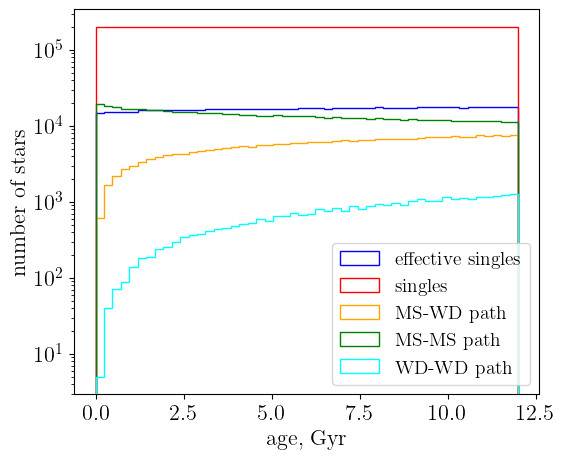

In [8]:
eff_singles['age']=present_day-eff_singles['bday']
# and just out of curiosity let's plot the distribution of ages
fig=plt.figure()
n_bins=50
(n, bins, patches)=plt.hist(eff_singles['age'], n_bins, histtype='step', stacked=True, fill=False, color='blue', label=r'effective singles')
plt.hist(mysingles['age'], bins, histtype='step', stacked=True, fill=False, color='red', label=r'singles')
plt.hist(mybin0['age'], bins, histtype='step', stacked=True, fill=False, color='orange', label=r'MS-WD path')
plt.hist(mybin1['age'], bins, histtype='step', stacked=True, fill=False, color='green', label=r'MS-MS path')
plt.hist(mybin2['age'], bins, histtype='step', stacked=True, fill=False, color='cyan', label=r'WD-WD path')
plt.yscale('log')
plt.xlabel(r'age, Gyr')
plt.ylabel('number of stars')
plt.legend(loc='lower right')
plt.show()

In [9]:
u=(eff_singles['class']==2)
print(len(eff_singles[u]))
# this agrees with the sum: MS-WD binaries disrupted + compact WD-WD binaries + 2*WD-WD binaries disrupted

98384


In [10]:
# just the wide binaries from each catalog
ind0=((mybin0['fsma']>=awide) & (mybin0['fsma']<alimit))
ind1=((mybin1['sma']>=awide) & (mybin1['sma']<alimit))
ind2=((mybin2['fsma2']>=awide) & (mybin2['fsma2']<alimit))
# MS-WD:
wbin0=Table(mybin0[ind0], copy=True)
# MS-MS:
wbin1=Table(mybin1[ind1], copy=True)
# WD-WD:
wbin2=Table(mybin2[ind2], copy=True)
wbinaries=len(wbin0)+len(wbin1)+len(wbin2)
print(wbinaries, nbinaries, len(wbin0), len(wbin1), len(wbin2))

48060 1000000 13843 32929 1288


In [11]:
# this is a parameter of the model: the overall fraction of the wide binary stars in the population
fbinaries=0.05
# maybe let's say for the purposes of the normalization that it's the main sequence binary fraction!
# then fbinaries should be equal to number of MS stars in binaries / number of all MS stars in the survey:
# fbinaries=(len(wbin0)+2*len(wbin1))/(len(mybin0)+2*len(mybin1)-len(eff_singles0)+single_norm*number of MS singles)
number_ms_singles=len(mysingles[(mysingles['class']==0.)])
print(number_ms_singles)
single_norm=((len(wbin0)+2*len(wbin1))/fbinaries-(len(mybin0)+2*len(mybin1)-len(eff_singles0)))/number_ms_singles
#single_norm=(2*wbinaries/fbinaries-len(eff_singles))/nsingles
print(nbinaries, nsingles, single_norm)
# OK, that seems a little low... basically it says that 2/3 of all systems are binaries, how do we feel about that? 

8258992
1000000 10000000 0.05804001263108137


In [12]:
# this is from the input file
mmin=0.3
mmax=7.2

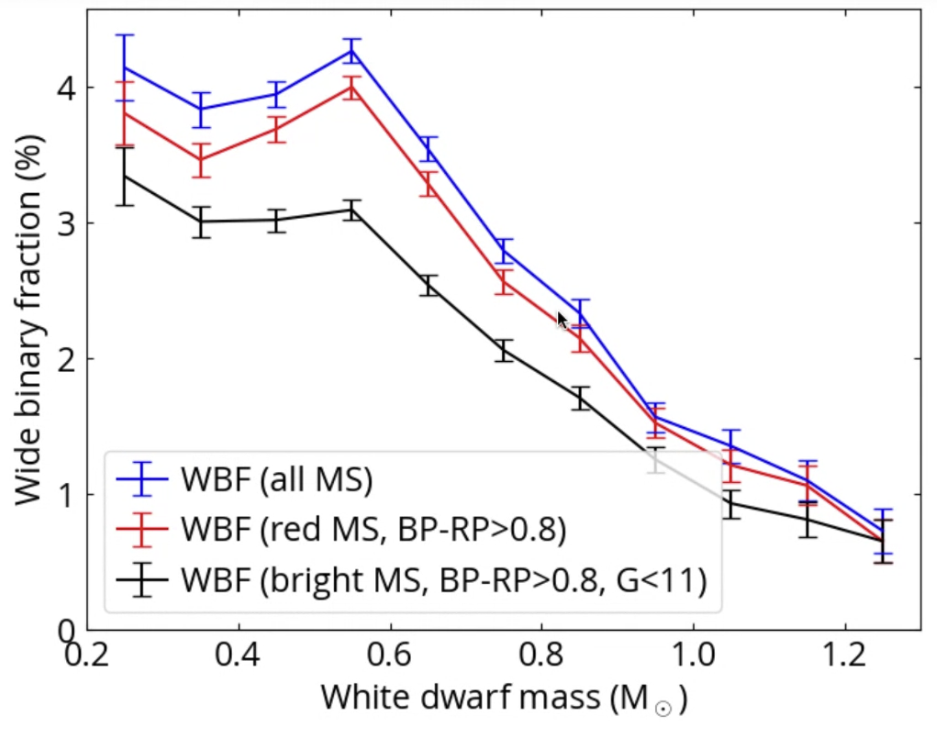

In [13]:
# reading data off the graph from Hsiang-Chih's dynamics plots:
m_red=1.069 # this is the mass that corresponds to BP-RP>0.8 cut
m_bright=0.394 # G<11 corresponds to BP-RP<2.826# this is the plot from Hsiang-Chih for WD binary fraction as a function of mass. 
# His wide binaries are defined to be between 1e3 and 1e4
from IPython.display import Image
Image(filename='hchwang_july_2_WDBF.png', width=500)


here we are using the singles normalization from the overall wide binary fraction:  0.05804001263108137


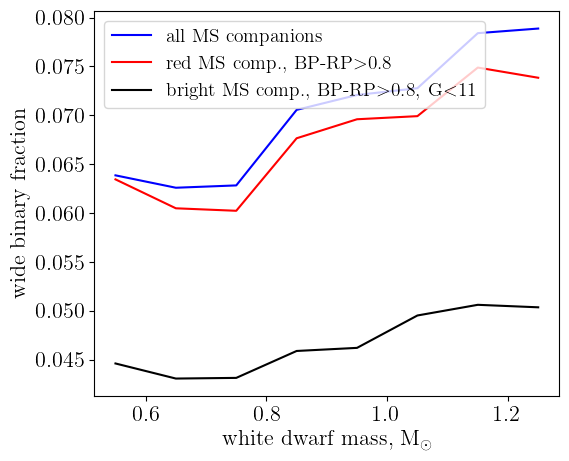

In [14]:
print('here we are using the singles normalization from the overall wide binary fraction: ', single_norm)
wd_bins=np.arange(0.25,1.35,0.1)
wd_bins_lo=np.arange(0.2,1.3,0.1)
wd_bins_hi=np.arange(0.3,1.4,0.1)
wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
for i,mass in enumerate(wd_bins):
    # OK, we are looking at WD-MS binaries and the mass is in the right bin and the separation
    # is in the right range
    ind0=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>awide) & (mybin0['fsma']<alimit))
    wdf[i]=len(mybin0[ind0])
    # now also add the criterion on the MS companion:
    ind0_red=(ind0 & (mybin0['m2']<m_red))
    wdf_red[i]=len(mybin0[ind0_red])
    # now also add the criterion that it should be bright:
    ind0_bright=(ind0_red & (mybin0['m2']>m_bright))
    wdf_bright[i]=len(mybin0[ind0_bright])
    
    # now let's look at the corresponding singles:
    ind1=((mysingles['fm']>=wd_bins_lo[i]) & (mysingles['fm']<wd_bins_hi[i]) & (mysingles['class']==2))
    wdf_single[i]=len(mysingles[ind1])
    
    # now let's look at the effective singles:
    ind2=((eff_singles['fm']>=wd_bins_lo[i]) & (eff_singles['fm']<wd_bins_hi[i]) & (eff_singles['class']==2))
    wdf_eff_single[i]=len(eff_singles[ind2])
temp=(wdf_single>0)
wdf_fraction=wdf[temp]/(wdf[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])    
wdf_fraction_red=wdf_red[temp]/(wdf[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])    
wdf_fraction_bright=wdf_bright[temp]/(wdf[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])   

fig=plt.figure()
plt.plot(wd_bins[temp],wdf_fraction,color='blue',label='all MS companions')
plt.plot(wd_bins[temp],wdf_fraction_red,color='red',label=r'red MS comp., BP-RP$>$0.8')
plt.plot(wd_bins[temp],wdf_fraction_bright,color='black',label=r'bright MS comp., BP-RP$>$0.8, G$<$11')
plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('wide binary fraction')
plt.legend(loc='upper left')
plt.show()

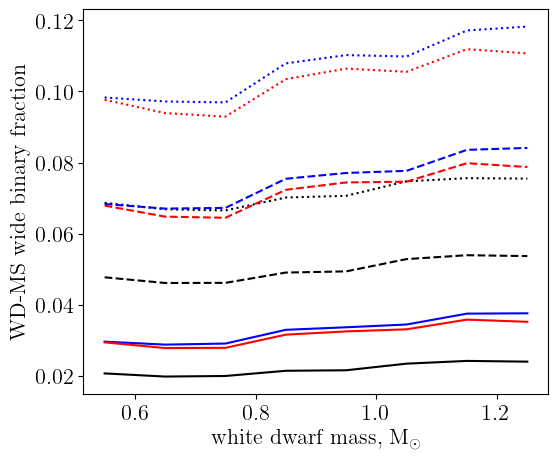

In [15]:
fig=plt.figure()
mystyles=['dotted', 'dashed', 'solid']
try_norm=[0.015, 0.05, 0.2]
best_norm=0.05
for j,single_norm in enumerate(try_norm):
    wd_bins=np.arange(0.25,1.35,0.1)
    wd_bins_lo=np.arange(0.2,1.3,0.1)
    wd_bins_hi=np.arange(0.3,1.4,0.1)
    wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
    for i,mass in enumerate(wd_bins):
        # OK, we are looking at WD-MS binaries and the mass is in the right bin and the separation
        # is in the right range
        ind0=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>awide) & (mybin0['fsma']<alimit))
        wdf[i]=len(mybin0[ind0])
        # now also add the criterion on the MS companion:
        ind0_red=(ind0 & (mybin0['m2']<m_red))
        wdf_red[i]=len(mybin0[ind0_red])
        # now also add the criterion that it should be bright:
        ind0_bright=(ind0_red & (mybin0['m2']>m_bright))
        wdf_bright[i]=len(mybin0[ind0_bright])

        # now let's look at the corresponding singles:
        ind1=((mysingles['fm']>=wd_bins_lo[i]) & (mysingles['fm']<wd_bins_hi[i]) & (mysingles['class']==2))
        wdf_single[i]=len(mysingles[ind1])

        # now let's look at the effective singles:
        ind2=((eff_singles['fm']>=wd_bins_lo[i]) & (eff_singles['fm']<wd_bins_hi[i]) & (eff_singles['class']==2))
        wdf_eff_single[i]=len(eff_singles[ind2])
        # so... this is not quite accurate. White dwarfs in MS-WD pairs but at wrong separations would also count
        # in the denominator, and so would WD-WD pairs which are not effective singles
        # and even though we don't really think this should matter, it would be really nice to include everything 
        # correctly, or at least explore how much this would matter... 
    temp=(wdf_single>0)
    wdf_fraction=wdf[temp]/(wdf[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])    
    wdf_fraction_red=wdf_red[temp]/(wdf[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])    
    wdf_fraction_bright=wdf_bright[temp]/(wdf[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])   

    plt.plot(wd_bins[temp],wdf_fraction,color='blue',linestyle=mystyles[j],label='WDF (all MS)')
    plt.plot(wd_bins[temp],wdf_fraction_red,color='red',linestyle=mystyles[j],label='WDF (red MS, BP-RP>0.8)')
    plt.plot(wd_bins[temp],wdf_fraction_bright,color='black',linestyle=mystyles[j],label='WDF (bright MS, BP-RP>0.8, G<11)')
    
plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('WD-MS wide binary fraction')
plt.show()

I am here


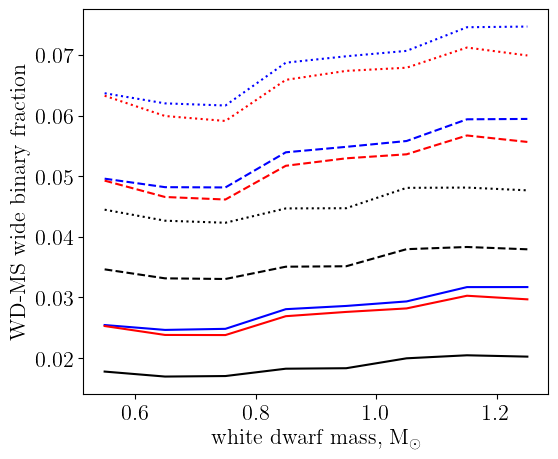

In [16]:
# OK, let's try again and see whether properly counting objects in the denominator makes a huge amount of difference
fig=plt.figure()
mystyles=['dotted', 'dashed', 'solid']
for j,single_norm in enumerate(try_norm):
    wd_bins=np.arange(0.25,1.35,0.1)
    wd_bins_lo=np.arange(0.2,1.3,0.1)
    wd_bins_hi=np.arange(0.3,1.4,0.1)
    wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single, wdf_other=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
    for i,mass in enumerate(wd_bins):
        # OK, we are looking at WD-MS binaries and the mass is in the right bin and the separation
        # is in the right range
        ind0=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>awide) & (mybin0['fsma']<alimit))
        wdf[i]=len(mybin0[ind0])
        # now also add the criterion on the MS companion:
        ind0_red=(ind0 & (mybin0['m2']<m_red))
        wdf_red[i]=len(mybin0[ind0_red])
        # now also add the criterion that it should be bright:
        ind0_bright=(ind0_red & (mybin0['m2']>m_bright))
        wdf_bright[i]=len(mybin0[ind0_bright])
        
        # now let's look at the corresponding singles:
        ind1=((mysingles['fm']>=wd_bins_lo[i]) & (mysingles['fm']<wd_bins_hi[i]) & (mysingles['class']==2))
        wdf_single[i]=len(mysingles[ind1])
        
        # now let's look at the effective singles:
        ind2=((eff_singles['fm']>=wd_bins_lo[i]) & (eff_singles['fm']<wd_bins_hi[i]) & (eff_singles['class']==2))
        wdf_eff_single[i]=len(eff_singles[ind2])

        # OK, if the WD is in the right mass range but in the wrong separation range, if it's not too close to the 
        # MS star, then it will be in the denominator. Let's take the max possible value here because it will make
        # the max possible difference with the previous plot, and then we'll know what the uncertainty is.
        # Because it's not really clear whether in a survey the binaries that are between 100 and 1000 AU are 
        # going to be resolved; here we are considering the largest-denominator scenario that they are
        ind0a=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>aclose))
        # but if they are in the right regime of separations, they have already been counted above... so we should
        # remove the original count from the denominator!! 
        # and the same for the WD-WD binaries (effective singles have already been counted, so we only need to
        # count bound WD-WD binaries at the wrong separations)
        ind2a=((mybin2['fm1']>=wd_bins_lo[i]) & (mybin2['fm1']<wd_bins_hi[i]) & (mybin2['fsma2']>aclose))
        ind2b=((mybin2['fm2']>=wd_bins_lo[i]) & (mybin2['fm2']<wd_bins_hi[i]) & (mybin2['fsma2']>aclose))
        # sum them up:
        wdf_other[i]=len(mybin0[ind0a])+len(mybin2[ind2a])+len(mybin2[ind2b])

    temp=(wdf_single>0)
    wdf_fraction=wdf[temp]/(wdf_eff_single[temp]+wdf_other[temp]+single_norm*wdf_single[temp])    
    wdf_fraction_red=wdf_red[temp]/(wdf_eff_single[temp]+wdf_other[temp]+single_norm*wdf_single[temp])    
    wdf_fraction_bright=wdf_bright[temp]/(wdf_eff_single[temp]+wdf_other[temp]+single_norm*wdf_single[temp])   

    plt.plot(wd_bins[temp],wdf_fraction,color='blue',linestyle=mystyles[j],label='WDF (all MS)')
    plt.plot(wd_bins[temp],wdf_fraction_red,color='red',linestyle=mystyles[j],label='WDF (red MS, BP-RP>0.8)')
    plt.plot(wd_bins[temp],wdf_fraction_bright,color='black',linestyle=mystyles[j],label='WDF (bright MS, BP-RP>0.8, G<11)')
    
    if (j==1):
        print('I am here')
        wdms=Table()
        wdms['wd_bins']=wd_bins[temp]
        wdms['frac']=wdf_fraction
        wdms['frac_red']=wdf_fraction_red
        wdms['frac_bright']=wdf_fraction_bright
    
plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('WD-MS wide binary fraction')
plt.show()
# OK, so there is a slight reduction in the fraction, as expected, but qualitatively the behavior doesn't change,
# and any intermediate ways of counting would be in between these curves and the previous curves, because we
# basically said that all objects above 100 AU are individually resolvable and count in the denominator, which
# I don't think is true. 

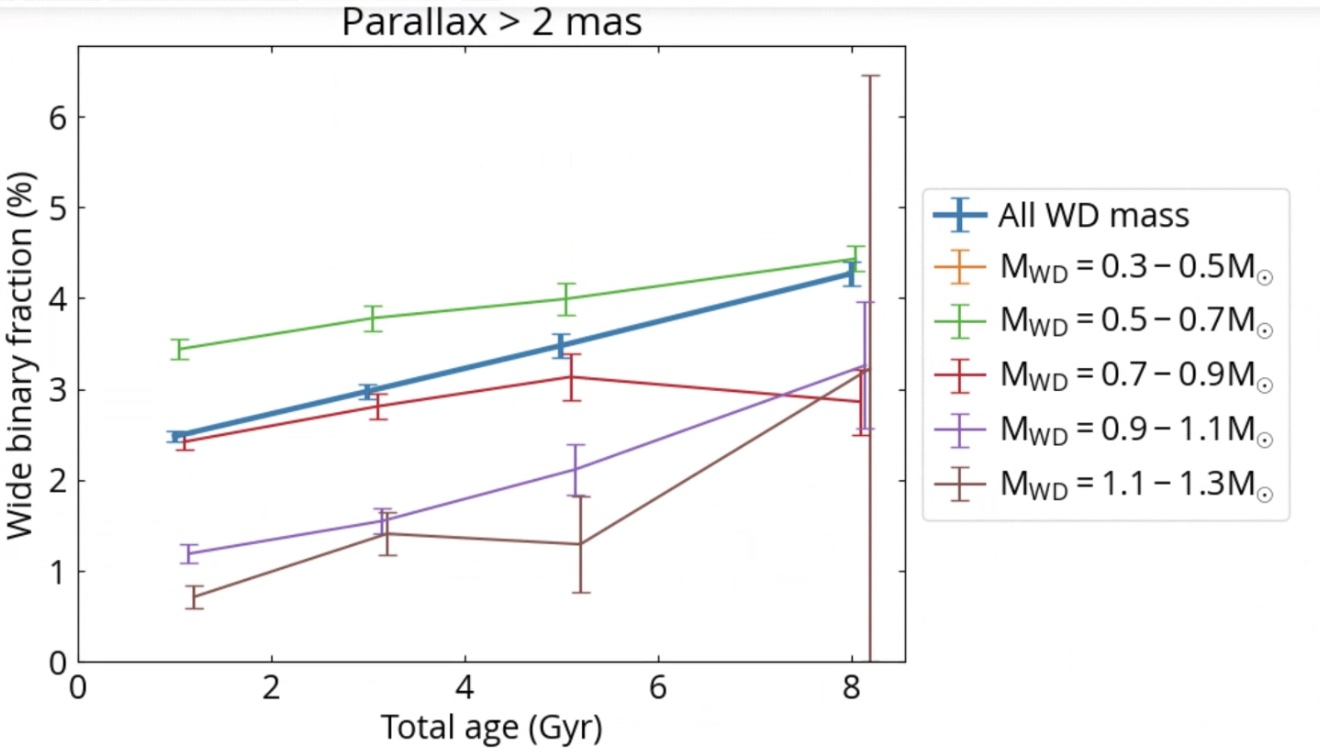

In [17]:
Image(filename='hchwang_july_2_WDBF_age.jpg', width=500)


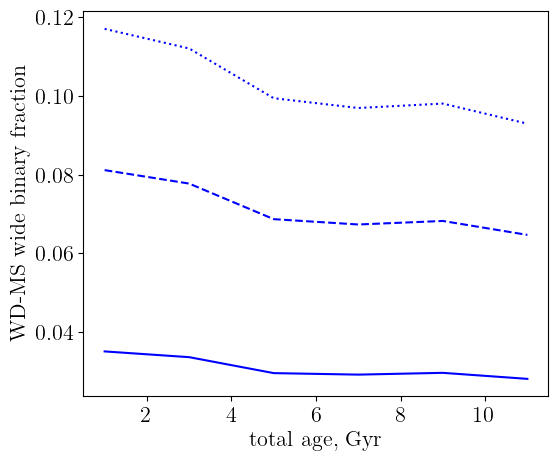

In [18]:
# OK, let's look as a function of age:
fig=plt.figure()
for j,single_norm in enumerate(try_norm):
    age_bins=np.arange(1,13,2)
    age_bins_lo=age_bins-1.
    age_bins_hi=age_bins+1.
    wdf, wdf_single, wdf_eff_single=np.zeros(len(age_bins)), np.zeros(len(age_bins)), np.zeros(len(age_bins))
    for i,age in enumerate(age_bins):
        # OK, we are looking at WD-MS binaries and the mass is in the right bin and the separation
        # is in the right range
        ind0=((mybin0['age']>=age_bins_lo[i]) & (mybin0['age']<age_bins_hi[i]) & (mybin0['fsma']>awide) & (mybin0['fsma']<alimit))
        wdf[i]=len(mybin0[ind0])

        # now let's look at the corresponding singles:
        ind1=((mysingles['age']>=age_bins_lo[i]) & (mysingles['age']<age_bins_hi[i]) & (mysingles['class']==2))
        wdf_single[i]=len(mysingles[ind1])
        if (wdf_single[i]==0):
            print('age=', age, ' single_norm=', single_norm)

        # now let's look at the effective singles:
        ind2=((eff_singles['age']>=age_bins_lo[i]) & (eff_singles['age']<age_bins_hi[i]) & (eff_singles['class']==2))
        wdf_eff_single[i]=len(eff_singles[ind2])
    wdf_fraction=wdf/(wdf+wdf_eff_single+single_norm*wdf_single)    
    plt.plot(age_bins,wdf_fraction,linestyle=mystyles[j],color='blue')
plt.xlabel('total age, Gyr')
plt.ylabel('WD-MS wide binary fraction')
plt.show()

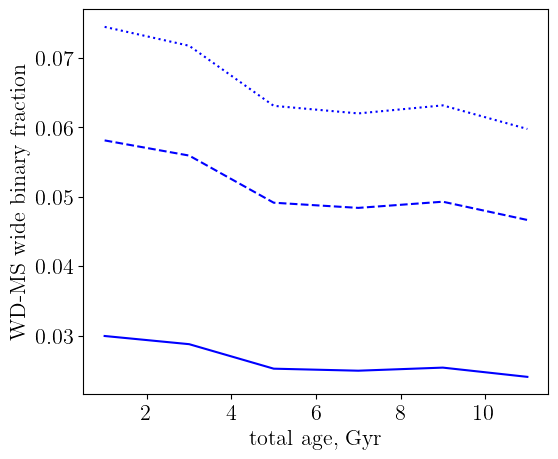

In [19]:
# Amend the previous plot with a better calculation of the denominator: 
fig=plt.figure()
for j,single_norm in enumerate(try_norm):
    age_bins=np.arange(1,13,2)
    age_bins_lo=age_bins-1.
    age_bins_hi=age_bins+1.
    wdf, wdf_single, wdf_other, wdf_eff_single=np.zeros(len(age_bins)), np.zeros(len(age_bins)), np.zeros(len(age_bins)), np.zeros(len(age_bins))
    for i,age in enumerate(age_bins):
        # OK, we are looking at WD-MS binaries and the mass is in the right bin and the separation
        # is in the right range
        ind0=((mybin0['age']>=age_bins_lo[i]) & (mybin0['age']<age_bins_hi[i]) & (mybin0['fsma']>awide) & (mybin0['fsma']<alimit))
        wdf[i]=len(mybin0[ind0])

        # now let's look at the corresponding singles:
        ind1=((mysingles['age']>=age_bins_lo[i]) & (mysingles['age']<age_bins_hi[i]) & (mysingles['class']==2))
        wdf_single[i]=len(mysingles[ind1])
        if (wdf_single[i]==0):
            print('age=', age, ' single_norm=', single_norm)

        # now let's look at the effective singles:
        ind2=((eff_singles['age']>=age_bins_lo[i]) & (eff_singles['age']<age_bins_hi[i]) & (eff_singles['class']==2))
        wdf_eff_single[i]=len(eff_singles[ind2])
        
        # now let's look at the binaries at all separations:
        ind0a=((mybin0['age']>=age_bins_lo[i]) & (mybin0['age']<age_bins_hi[i]) & (mybin0['fsma']>aclose))
        ind2a=((mybin2['age']>=age_bins_lo[i]) & (mybin2['age']<age_bins_hi[i]) & (mybin2['fsma2']>aclose))
        # count them up
        wdf_other[i]=len(mybin0[ind0a])+2*len(mybin2[ind2a])
        # and these ones already include all of the WD-MS binaries at the correct separation, so no need to include
        # wdf in the denominator:
    wdf_fraction=wdf/(wdf_other+wdf_eff_single+single_norm*wdf_single)    
    plt.plot(age_bins,wdf_fraction,linestyle=mystyles[j],color='blue')
plt.xlabel('total age, Gyr')
plt.ylabel('WD-MS wide binary fraction')
plt.show()
# also slightly lower, as expected, but no change in qualitative behavior... 

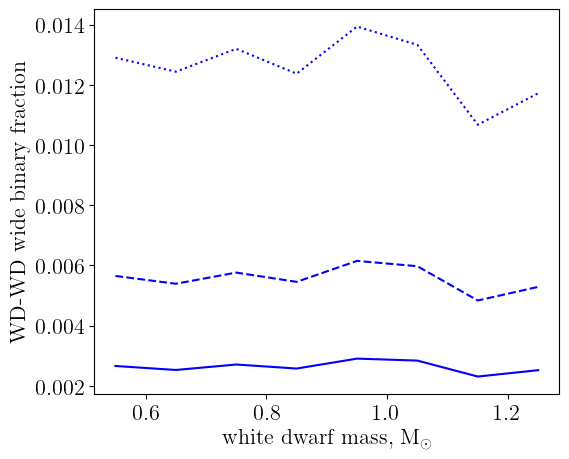

In [20]:
# OK, one more thing is the WD-WD wide binary fraction as a function of mass... 
# let's do a "minimum" denominator calculation first: 
fig=plt.figure()
mystyles=['dotted', 'dashed', 'solid']
wd_bins=np.arange(0.25,1.35,0.1)
wd_bins_lo=np.arange(0.2,1.3,0.1)
wd_bins_hi=np.arange(0.3,1.4,0.1)
for j,single_norm in enumerate([0.05, 0.2, 0.5]):
    wdf, wdf_other, wdf_single, wdf_eff_single=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
    for i,mass in enumerate(wd_bins):
        # OK, we are looking at WD-WD binaries and the mass is in the right bin and the separation
        # is in the right range
        ind2a=((mybin2['fm1']>=wd_bins_lo[i]) & (mybin2['fm1']<wd_bins_hi[i]) & (mybin2['fsma2']>awide) & (mybin2['fsma2']<alimit))
        ind2b=((mybin2['fm2']>=wd_bins_lo[i]) & (mybin2['fm2']<wd_bins_hi[i]) & (mybin2['fsma2']>awide) & (mybin2['fsma2']<alimit))
        wdf[i]=len(mybin2[ind2a])+len(mybin2[ind2b])
        
        # now let's look at the corresponding singles:
        ind1=((mysingles['fm']>=wd_bins_lo[i]) & (mysingles['fm']<wd_bins_hi[i]) & (mysingles['class']==2))
        wdf_single[i]=len(mysingles[ind1])

        # now let's look at the effective singles:
        ind3=((eff_singles['fm']>=wd_bins_lo[i]) & (eff_singles['fm']<wd_bins_hi[i]) & (eff_singles['class']==2))
        wdf_eff_single[i]=len(eff_singles[ind3])

        # there are no white dwarfs in the mybin1 table
        # count up the white dwarfs in the mybin0 table, but only if they are well spatially resolved from the MS star:
        ind0=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>awide))
        wdf_other[i]=len(mybin0[ind0])
        
    temp=(wdf_single>0)
    wdf_fraction=wdf[temp]/(wdf[temp]+wdf_other[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])    

    plt.plot(wd_bins[temp],wdf_fraction,color='blue',linestyle=mystyles[j],label='WDF (all MS)')
    
plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('WD-WD wide binary fraction')
plt.show()

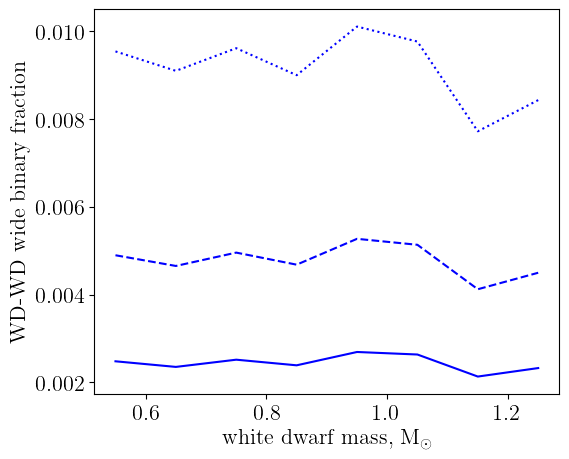

In [21]:
# same, but maximize the denominator and see how much difference this makes:
# include MS-WD binaries that are poorly resolved and WD-WD binaries at all separations
fig=plt.figure()
mystyles=['dotted', 'dashed', 'solid']
wd_bins=np.arange(0.25,1.35,0.1)
wd_bins_lo=np.arange(0.2,1.3,0.1)
wd_bins_hi=np.arange(0.3,1.4,0.1)
for j,single_norm in enumerate([0.05, 0.2, 0.5]):
    wdf, wdf_other, wdf_single, wdf_eff_single=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
    for i,mass in enumerate(wd_bins):
        # OK, we are looking at WD-WD binaries and the mass is in the right bin and the separation
        # is in the right range
        ind2a=((mybin2['fm1']>=wd_bins_lo[i]) & (mybin2['fm1']<wd_bins_hi[i]) & (mybin2['fsma2']>awide) & (mybin2['fsma2']<alimit))
        ind2b=((mybin2['fm2']>=wd_bins_lo[i]) & (mybin2['fm2']<wd_bins_hi[i]) & (mybin2['fsma2']>awide) & (mybin2['fsma2']<alimit))
        wdf[i]=len(mybin2[ind2a])+len(mybin2[ind2b])
        
        # now let's look at the corresponding singles:
        ind1=((mysingles['fm']>=wd_bins_lo[i]) & (mysingles['fm']<wd_bins_hi[i]) & (mysingles['class']==2))
        wdf_single[i]=len(mysingles[ind1])

        # now let's look at the effective singles:
        ind3=((eff_singles['fm']>=wd_bins_lo[i]) & (eff_singles['fm']<wd_bins_hi[i]) & (eff_singles['class']==2))
        wdf_eff_single[i]=len(eff_singles[ind3])

        # there are no white dwarfs in the mybin1 table
        # count up the white dwarfs in the mybin0 table, but only if they are not in effective singles: 
        ind0=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>aclose))
        # count up the white dwarfs in the mybin2 table at all separations: 
        ind2c=((mybin2['fm1']>=wd_bins_lo[i]) & (mybin2['fm1']<wd_bins_hi[i]) & (mybin2['fsma2']>aclose))
        ind2d=((mybin2['fm2']>=wd_bins_lo[i]) & (mybin2['fm2']<wd_bins_hi[i]) & (mybin2['fsma2']>aclose))
        wdf_other[i]=len(mybin0[ind0])+len(mybin2[ind2c])+len(mybin2[ind2d])

    temp=(wdf_single>0)
    wdf_fraction=wdf[temp]/(wdf_other[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])    
    
    plt.plot(wd_bins[temp],wdf_fraction,color='blue',linestyle=mystyles[j],label='WDF (all MS)')
    
    if (j==1):
        wdwd=Table()
        wdwd['wd_bins']=wd_bins[temp]
        wdwd['frac']=wdf_fraction

plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('WD-WD wide binary fraction')
plt.show()

<h1>Show MS-MS, MS-WD and WD-WD binary fractions on the same plot and calculate the retention fraction</h1>

In [22]:
# inverting Cummings:
from scipy.interpolate import interp1d
def mfinal(minitial):
    # this is the initial-to-final relationship from Cummings et al. 2018
    # supplemented by constant fractional mass loss at M<0.83
    minitial=np.array([minitial])
    ind0=(minitial<=0.83)
    ind1=((minitial>0.83) & (minitial<=2.85))
    ind2=((minitial>2.85) & (minitial<=3.60))
    ind3=((minitial>3.60) & (minitial<=7.20))
    ind4=(minitial>7.20)
    mf=0.*minitial
    mf[ind0]=minitial[ind0]*(0.08*0.83+0.489)/0.83
    mf[ind1]=0.08*minitial[ind1]+0.489
    mf[ind2]=0.187*minitial[ind2]+0.184
    mf[ind3]=0.107*minitial[ind3]+0.471
    mf[ind4]=minitial[ind4]*(0.107*7.2+0.471)/7.2
    if (len(minitial)==1): 
        return(mf[0])
    else:
        return(mf)
minitial=np.arange(0.5,10.,0.1)
mf=mfinal(minitial)
invert_cummings = interp1d(mf, minitial, kind='cubic')


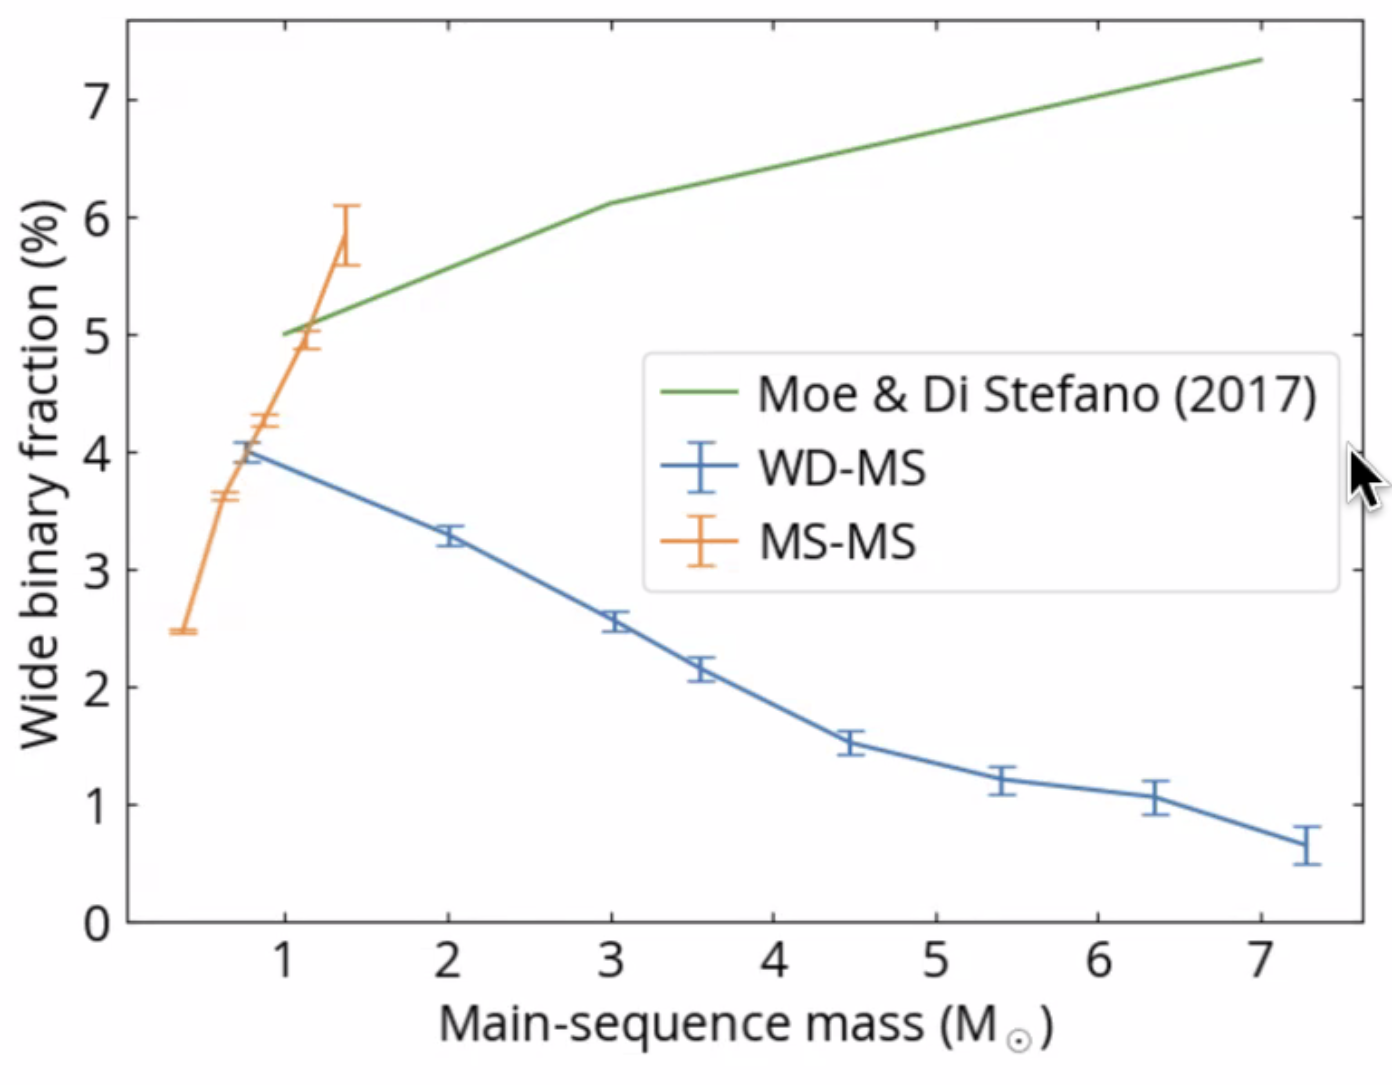

In [23]:
Image(filename='hchwang_july_9_MS_vs_WD.png', width=500)


In [24]:
wd_bins=wdms['wd_bins']
delta_bins=wd_bins[1]-wd_bins[0]
wd_bins_lo=wd_bins-delta_bins
wd_bins_hi=wd_bins+delta_bins
ms_bins=invert_cummings(wd_bins)
ms_bins_lo=invert_cummings(wd_bins_lo)
ms_bins_hi=invert_cummings(wd_bins_hi)
# set up vectors for all values defaulting to -1 to catch any bins where we don't have any objects,
# although I think I removed the problematic low-mass bins already
msms, msms_red, msms_bright, msms_single, msms_other = np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1.


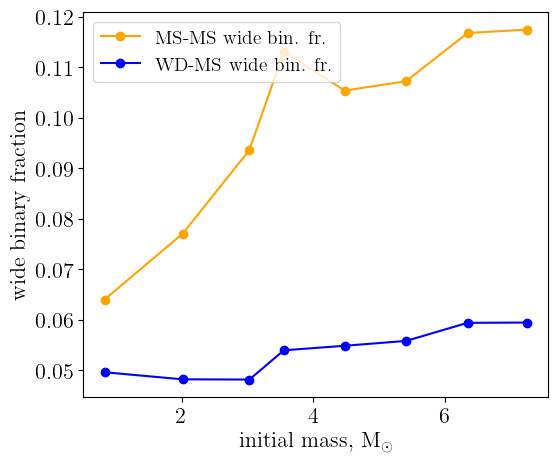

In [25]:
single_norm=best_norm # same normalization as for the WDMS and WDWD calculations, I think, but this would need to be tracked carefully
for i,mass in enumerate(ms_bins):
    # MS-MS wide-binary fraction: only mybin0 and mybin1 matter
    # numerator
    ind1a=((mybin1['sma']>awide) & (mybin1['sma']<alimit) & (mybin1['m1']>=ms_bins_lo[i]) & (mybin1['m1']<ms_bins_hi[i]))
    ind1b=((mybin1['sma']>awide) & (mybin1['sma']<alimit) & (mybin1['m2']>=ms_bins_lo[i]) & (mybin1['m2']<ms_bins_hi[i]))
    msms[i]=len(mybin1[ind1a])+len(mybin1[ind1b])
    # now also add the red criterion on the MS companion:
    ind1c=(ind1a & (mybin1['m2']<m_red))
    ind1d=(ind1b & (mybin1['m1']<m_red))
    msms_red[i]=len(mybin1[ind1c])+len(mybin1[ind1d])
    # now also add the bright criterion on the MS companion:
    ind1e=(ind1c & (mybin1['m2']>m_bright))
    ind1f=(ind1d & (mybin1['m1']>m_bright))
    msms_bright[i]=len(mybin1[ind1e])+len(mybin1[ind1f])
    
    # denominator: all of the MS from WD-MS pairs count
    ind0=((mybin0['m2']>=ms_bins_lo[i]) & (mybin0['m2']<ms_bins_hi[i]))
    # effective singles have to be computed specially. Nothing comes from mybin2. 
    # Mybin0 is already fully taken into account at all separations. We need to consider mybin1, either close binaries
    # or those that are not in close binaries but are not in wide binaries either.
    # for close binaries, it's the more massive star 1 that should be in the mass range:
    eff1=((mybin1['sma']<aclose) & (mybin1['m1']>=ms_bins_lo[i]) & (mybin1['m1']<ms_bins_hi[i]))
    # for all other binaries: 
    eff1a=((mybin1['sma']>aclose) & (mybin1['m1']>=ms_bins_lo[i]) & (mybin1['m1']<ms_bins_hi[i]))
    eff1b=((mybin1['sma']>aclose) & (mybin1['m2']>=ms_bins_lo[i]) & (mybin1['m2']<ms_bins_hi[i]))
    msms_other[i]=len(mybin0[ind0])+len(mybin1[eff1])+len(mybin1[eff1a])+len(mybin1[eff1b])
    
    # singles
    inds=((mysingles['m']>=ms_bins_lo[i]) & (mysingles['m']<ms_bins_hi[i]) & (mysingles['class']==0))
    msms_single[i]=len(mysingles[inds])
    
        
msms_fraction=msms/(msms+msms_other+single_norm*msms_single)
msms_fraction_red=msms_red/(msms+msms_other+single_norm*msms_single)
msms_fraction_bright=msms_bright/(msms+msms_other+single_norm*msms_single)

plt.plot(ms_bins, msms_fraction, color='orange', marker='o', label='MS-MS wide bin. fr.')                                  
plt.plot(ms_bins, wdms['frac'],color='blue', marker='o', label='WD-MS wide bin. fr.')                                  
#plt.plot(ms_bins, wdwd['frac'],color='red', marker='o', label='WD-WD wide bin. fr.')                                  
plt.xlabel(r'initial mass, M$_{\odot}$')
plt.ylabel('wide binary fraction')
plt.legend(loc='upper left')
plt.show()

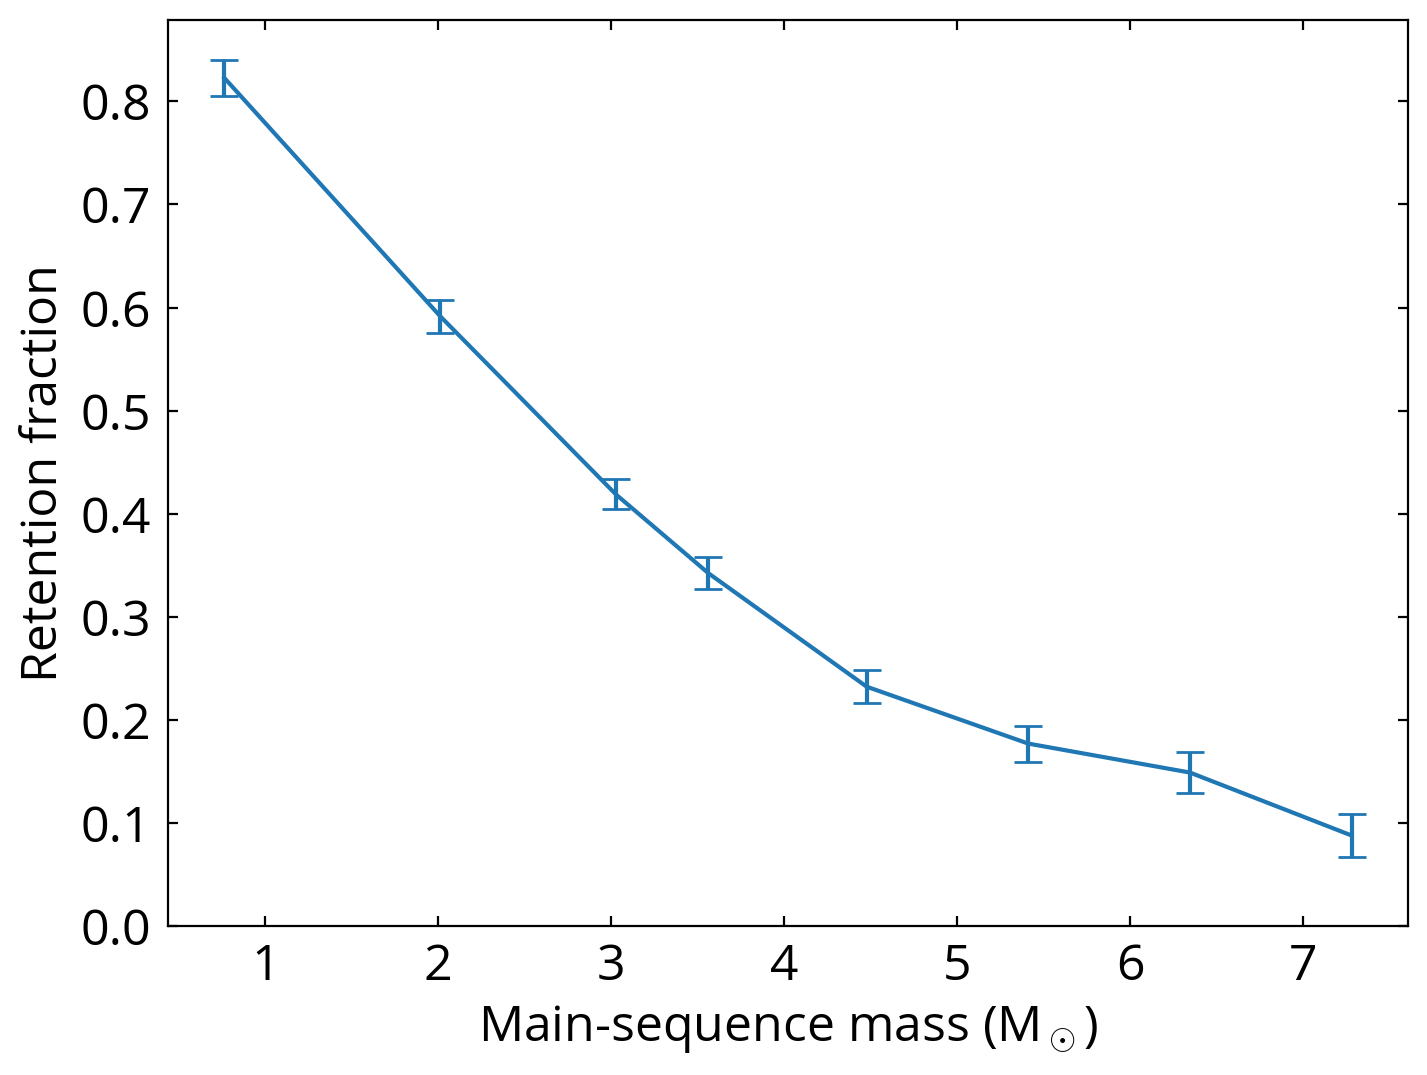

In [26]:
Image(filename='hchwang_retention_old.png', width=500)


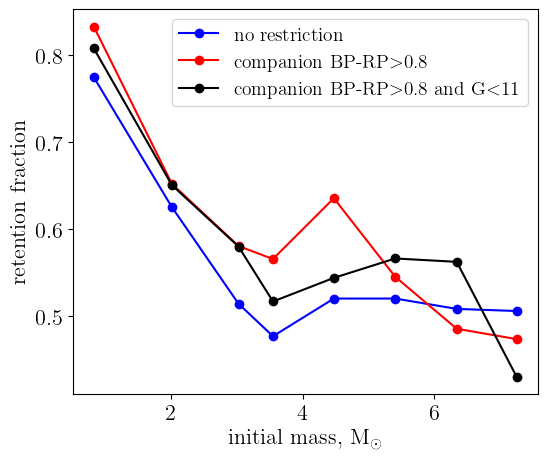

In [27]:
plt.figure()
plt.plot(ms_bins,wdms['frac']/msms_fraction, color='blue', marker='o', label='no restriction')
plt.plot(ms_bins,wdms['frac_red']/msms_fraction_red, color='red', marker='o', label=r'companion BP-RP$>$0.8')
plt.plot(ms_bins,wdms['frac_bright']/msms_fraction_bright, color='black', marker='o', label=r'companion BP-RP$>$0.8 and G$<$11')
plt.xlabel(r'initial mass, M$_{\odot}$')
plt.ylabel('retention fraction')
plt.legend(loc='upper right')
plt.show()

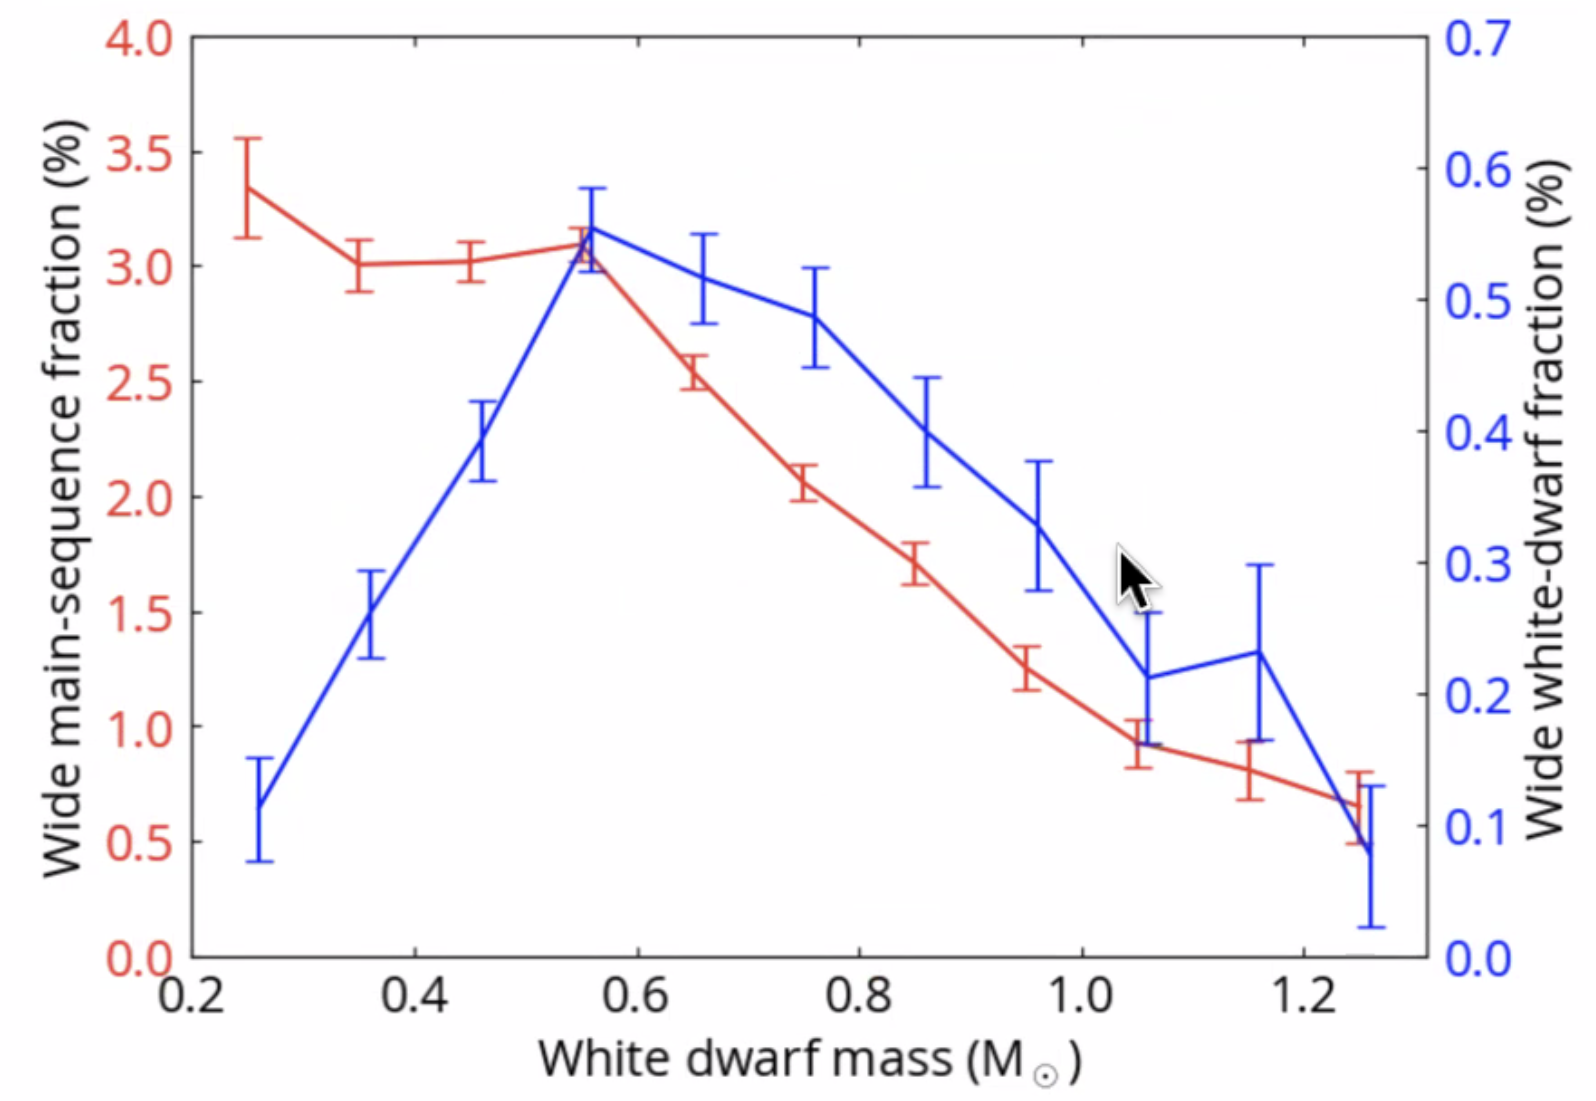

In [28]:
Image(filename='hchwang_july_9_WDMS_WDWD.png', width=500)


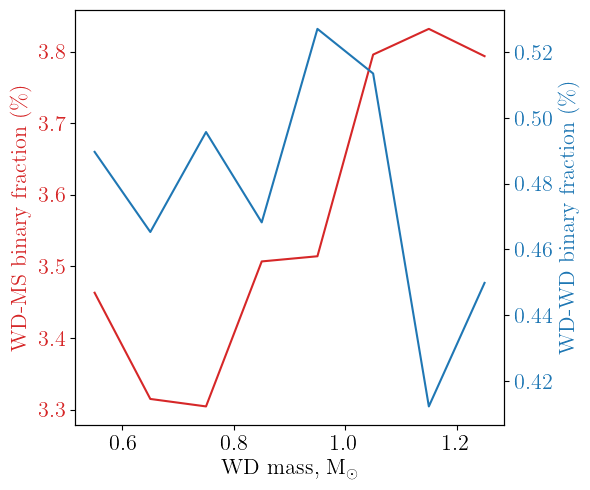

In [29]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'WD mass, M$_{\odot}$')
ax1.set_ylabel(r'WD-MS binary fraction (\%)', color=color)
ax1.plot(wd_bins, wdms['frac_bright']*100, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'WD-WD binary fraction (\%)', color=color)  # we already handled the x-label with ax1
ax2.plot(wd_bins, wdwd['frac']*100, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()